## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.linear_model import RidgeClassifierCV
from sktime.datasets import load_arrow_head
from sklearn.model_selection import train_test_split
from typing import NamedTuple, List

In /home/omrik/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/omrik/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/omrik/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


## Data

**Dataset taken from here - https://timeseriesclassification.com/description.php?Dataset=ArrowHead**

In [2]:
X, y = load_arrow_head(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(158, 1) (158,) (53, 1) (53,)


### histogram of classes

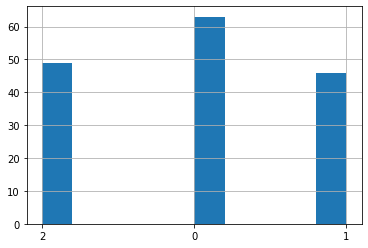

In [3]:
y_train.hist()

In [4]:
# binary target variable
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

['0' '1' '2'] [63 46 49]


### classes time series distribution

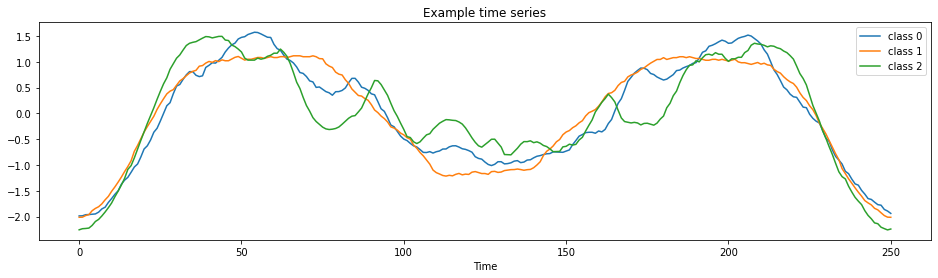

In [5]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
    X_train.loc[y_train == label, "dim_0"].iloc[0].plot(ax=ax, label=f"class {label}")
plt.legend()
ax.set(title="Example time series", xlabel="Time");

## Data clasees

In [6]:
class RocketKernels(NamedTuple):
    weights: List[float]
    lengths: List[int]
    biases: List[float]
    dilations: List[int]
    paddings: List[int]

In [7]:
RocketKernels([], [], [], [], [])

RocketKernels(weights=[], lengths=[], biases=[], dilations=[], paddings=[])

## ROCKET

In [8]:
class Rocket:
    def __init__(self, num_kernels, kernel_lengths = [7, 8, 9]):
        self.num_kernels = num_kernels
        self.kernel_lengths = kernel_lengths
        self.classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
        
    @staticmethod
    def apply_padding(kernel_length, kernel_dilation):
        if np.random.binomial(1, 0.5) == 1:
            return ((kernel_length - 1) * kernel_dilation)
        else:
            return 0
        
    def generate_random_kernels(self, input_size):
        kernel_lengths = np.array([
            random.choice(self.kernel_lengths)
            for i in range(self.num_kernels)
        ])
        
        # init kernels hyperparameters
        weights = np.zeros(kernel_lengths.sum(), dtype=np.float64)
        biases = np.zeros(self.num_kernels, dtype=np.float64)
        dilations = np.zeros(self.num_kernels, dtype=np.int32)
        paddings = np.zeros(self.num_kernels, dtype=np.int32)
    
        
        kernel_weights_start_idx = 0
        for kernel_idx in range(self.num_kernels):
            kernel_length = kernel_lengths[kernel_idx]
            kernel_weights = np.random.normal(0, 1, kernel_length)
            kernel_weights_end_idx = kernel_weights_start_idx + kernel_length
            
            # add to weights matrix random weights sampled from normal distribution.
            # normalize the weights by mean centering - always centering.
            weights[kernel_weights_start_idx:kernel_weights_end_idx] = kernel_weights / kernel_weights.mean()
            biases[kernel_idx] = np.random.uniform(-1, 1)
            
            # add dilations with according to the paper.
            # Use sampling from the above uniform distribution because it 
            # ensures that the effective length of the kernel, including dilation, i
            # is up to the length of the input time series
            dilation_ratio = input_size - 1 / kernel_length - 1
            kernel_dilation =  int(2 ** np.random.uniform(0, np.log2(dilation_ratio)))
            dilations[kernel_idx] = kernel_dilation
            
            # apply padding in random
            padding = Rocket.apply_padding(kernel_length, kernel_dilation)
            paddings[kernel_idx] = padding
            
            # move to next kernel
            kernel_weights_start_idx = kernel_weights_end_idx
            
        return RocketKernels(
            weights=weights,
            lengths=kernel_lengths,
            biases=biases,
            dilations=dilations,
            paddings=paddings
        )
    
    def apply_single_kernel(self, sample, length, weights, bias, dilation, padding):
        sample_length = len(sample)
        # output dervied from the following sample series:
        # ...[len(padding)]...[[t_1,_2....t_(len(dilation))] * len(length)]...[len(padding)]
        effective_kernel_length = dilation * (length - 1)
        padded_output_length = (sample_length + (2 * padding)) - effective_kernel_length
        
        # init 2 features - ppv and g_max_pooling
        g_max_pooling = 0
        ppv = 0
        
        for sample_idx in range(-padding, (sample_length + padding) - effective_kernel_length):
            l_max_pooling = bias
            input_dilaton_idx = sample_idx
            
            # impelement the paper formula - Sum_j(X_i*(j * d) * W_j) where j in running over the kernels
            for kernel_idx in range(length):
                if input_dilaton_idx >= 0 and input_dilaton_idx < sample_length:
                    l_max_pooling += sample[input_dilaton_idx] * weights[kernel_idx]
                input_dilaton_idx += dilation
            
            # set global max pooling and PPV
            if l_max_pooling > g_max_pooling:
                g_max_pooling = l_max_pooling
            if l_max_pooling > 0.:
                ppv += 1
                
        return g_max_pooling, ppv / padded_output_length
                   
    
    def apply_kernels(self, data_input, kernels):
        num_samples = len(data_input)
        
        data_applied_kernels = np.zeros((num_samples, 2 * self.num_kernels), dtype=np.float)
        
        for sample_idx in range(num_samples):
            weights_idx = 0
            features_idx = 0
            for kerenl_idx in range(self.num_kernels):
                kernel_weights_idx = weights_idx + kernels.lengths[kerenl_idx]
                kernel_features_idx = features_idx + 2
                data_applied_kernels[sample_idx, features_idx:kernel_features_idx] = self.apply_single_kernel(
                    sample=data_input.iloc[sample_idx],
                    length=kernels.lengths[kerenl_idx],
                    weights=kernels.weights[weights_idx:kernel_weights_idx],
                    bias=kernels.biases[kerenl_idx],
                    dilation=kernels.dilations[kerenl_idx],
                    padding=kernels.paddings[kerenl_idx])
            
                weights_idx = kernel_weights_idx
                features_idx = kernel_features_idx
        return data_applied_kernels
    
    def preprocess(self, labled_dataset, kernels):
        return self.apply_kernels(labled_dataset['data'], kernels), labled_dataset['label']
    
    def train(self, train_data, kernels):
        train_samples, train_labels = self.preprocess(train_data, kernels)
        self.classifier.fit(train_samples, train_labels)
        
    def test(self, test_data, kernels):
        test_samples, test_labels = self.preprocess(test_data, kernels)
        predictions = self.predict(test_samples)
        predictions = predictions.astype(np.int)
        return predictions
    
    def predict(self, data):
        return self.classifier.predict(data)

### ROCKET validations

In [9]:
rocket = Rocket(100)

In [10]:
kernels = rocket.generate_random_kernels(X_train.iloc[0]["dim_0"].shape)
assert len(kernels.lengths) == 100
assert len([k for k in kernels.paddings if k == 0]) > 0

### Training Classifier

In [11]:
train_data = X_train.join(pd.DataFrame(data=y_train.values, index=y_train.index))\
.rename(columns={'dim_0': 'data', 0: 'label'})

In [12]:
print(train_data[train_data['label'] == '0'].count())
print(y_train[y_train == '0'].count())

data     94
label    94
dtype: int64
63


In [13]:
rocket.train(train_data, kernels)

### Classifier Evaluations

In [14]:
test_data = X_test.join(pd.DataFrame(data=y_test.values, index=y_test.index))\
.rename(columns={'dim_0': 'data', 0: 'label'})

In [15]:
# predictions = classifier.predict(test_samples)
predictions = rocket.test(test_data, kernels)

In [16]:
predictions

array([1, 1, 1, 0, 2, 2, 0, 1, 0, 0, 1, 2, 1, 2, 1, 0, 1, 0, 1, 2, 1, 2,
       1, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 2, 0, 0, 0, 2,
       2, 0, 2, 1, 0, 1, 0, 1, 2])

In [18]:
test_project_labels = test_data['label'].values.astype(np.int)

In [19]:
acc = np.abs(test_project_labels - predictions)

### Accuracy

In [20]:
acc = np.abs(test_project_labels - predictions)

In [21]:
acc_pre = (len(acc) - len(acc.nonzero())) / len(acc)

In [22]:
print(f"{acc_pre * 100}% accuracy on test set")

98.11320754716981% accuracy on test set
